In [1]:
import pandas as pd

data = pd.read_csv('data.csv')
data.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [2]:
data['class']= data['class'].map({'P':1, 'H':0})
data['class'].head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [3]:
X = data.drop(columns=['ID', 'class'], axis=1).to_numpy()
X

array([[5.16000000e+03, 1.25000000e-05, 1.20804174e+02, ...,
        1.74927817e+03, 2.96102768e+05, 1.44605000e+05],
       [5.19800000e+04, 1.60000000e-05, 1.15318238e+02, ...,
        1.50476827e+03, 2.78744285e+05, 2.98640000e+05],
       [2.60000000e+03, 1.03000000e-05, 2.29933997e+02, ...,
        1.43144349e+03, 1.44411706e+05, 7.90250000e+04],
       ...,
       [3.83000000e+03, 8.36000000e-06, 1.51536989e+02, ...,
        1.91557349e+03, 1.28727124e+05, 8.34450000e+04],
       [1.76000000e+03, 7.96000000e-06, 2.89518195e+02, ...,
        1.91557349e+03, 1.28727124e+05, 8.34450000e+04],
       [2.87500000e+03, 8.18000000e-06, 2.35769350e+02, ...,
        1.91557349e+03, 1.28727124e+05, 8.34450000e+04]])

In [4]:
y = data['class'].to_numpy()

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
X_train.shape

(156, 450)

In [7]:
from keras.layers import Input, Dense, Dropout, Conv1D, Flatten,MaxPooling1D
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.optimizers import Adam

2024-07-21 08:06:23.707065: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 08:06:23.710660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 08:06:23.721108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 08:06:23.735899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 08:06:23.740101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 08:06:23.750603: I tensorflow/core/platform/cpu_feature_gu

In [8]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(452,1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))

model.add(Dense(1, activation='sigmoid'))


/home/amin/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5716 - loss: 4.7098 - val_accuracy: 0.5000 - val_loss: 2.7880
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6931 - loss: 2.3638 - val_accuracy: 0.5000 - val_loss: 1.3740
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6937 - loss: 1.2283 - val_accuracy: 0.7222 - val_loss: 0.9529
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7213 - loss: 0.9026 - val_accuracy: 0.8333 - val_loss: 0.7697
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7181 - loss: 0.7669 - val_accuracy: 0.8333 - val_loss: 0.6789
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7038 - loss: 0.7101 - val_accuracy: 0.7778 - val_loss: 0.6575
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8212 - loss: 0.6345 - val_accuracy: 0.8333 - val_loss: 0.5789
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8449 - loss: 0.5414 - val_accuracy: 0.7778 - 

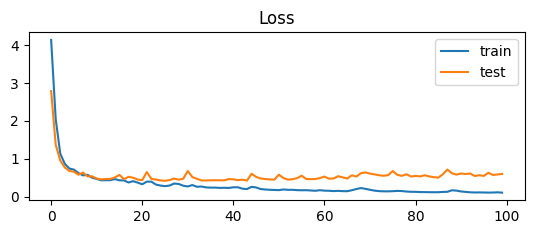

In [11]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.show()

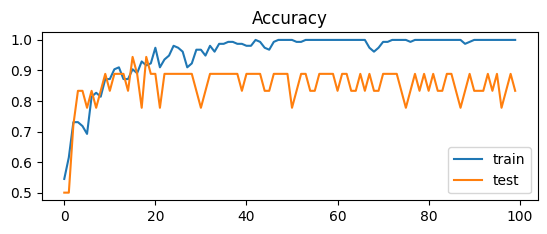

In [12]:
# plot mse during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()